In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv('all_coordinates-45min.csv')

df.columns

df = df[['frame_index','ball_coords']]
df.head()

df.size

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert 'ball_coords' from string to two float columns
df[['ball_x', 'ball_y']] = df['ball_coords'].str.extract(r'\((.*), (.*)\)').astype(float)

# Normalize frame_index for color mapping
norm = plt.Normalize(df['frame_index'].min(), df['frame_index'].max())
colors = plt.cm.coolwarm(norm(df['frame_index']))

plt.figure(figsize=(8, 6))
sc = plt.scatter(df['ball_x'], df['ball_y'], c=df['frame_index'], cmap='coolwarm')
plt.xlabel('Ball X')
plt.ylabel('Ball Y')
plt.title('Ball Coordinates on 2D Plane')
plt.colorbar(sc, label='Frame Index')
plt.legend()
plt.show()

LSTM

In [19]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Ensure frame_index is continuous
all_frames = pd.DataFrame({'frame_index': range(df['frame_index'].min(), df['frame_index'].max() + 1)})
df_full = pd.merge(all_frames, df, on='frame_index', how='left')

# Interpolate missing positions for training (or mask for prediction)
df_full[['ball_x', 'ball_y']] = df_full[['ball_x', 'ball_y']].interpolate()

# Drop any rows still containing NaN (e.g., at the start or end)
df_full = df_full.dropna(subset=['ball_x', 'ball_y']).reset_index(drop=True)

# Prepare sequences
SEQ_LEN = 10  # Number of previous frames to use

class BallDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data.iloc[idx:idx+self.seq_len][['ball_x', 'ball_y']].values.astype(np.float32)
        target = self.data.iloc[idx+self.seq_len][['ball_x', 'ball_y']].values.astype(np.float32)
        return torch.tensor(seq), torch.tensor(target)

dataset = BallDataset(df_full, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [20]:
#LSTM Model
class BallLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = BallLSTM()

In [21]:
#Train Model
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
for epoch in range(EPOCHS):
    for seq, target in dataloader:
        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 1049014.1250
Epoch 2, Loss: 536139.7500
Epoch 3, Loss: 800652.0000
Epoch 4, Loss: 576888.7500
Epoch 5, Loss: 697155.3125
Epoch 6, Loss: 776835.9375
Epoch 7, Loss: 1003374.8125
Epoch 8, Loss: 777675.5625
Epoch 9, Loss: 747823.9375
Epoch 10, Loss: 814066.2500


In [24]:
#Predict Missing Values
def predict_missing(df_full, model, seq_len):
    model.eval()
    with torch.no_grad():
        for idx, row in df_full[df_full['ball_x'].isna()].iterrows():
            if idx < seq_len:
                continue
            seq = df_full.iloc[idx-seq_len:idx][['ball_x', 'ball_y']].values
            if np.isnan(seq).any():
                continue  # skip if sequence has missing values
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)
            pred = model(seq_tensor).numpy().flatten()
            df_full.at[idx, 'ball_x'] = pred[0]
            df_full.at[idx, 'ball_y'] = pred[1]
    return df_full

df_predicted = predict_missing(df_full.copy(), model, SEQ_LEN)

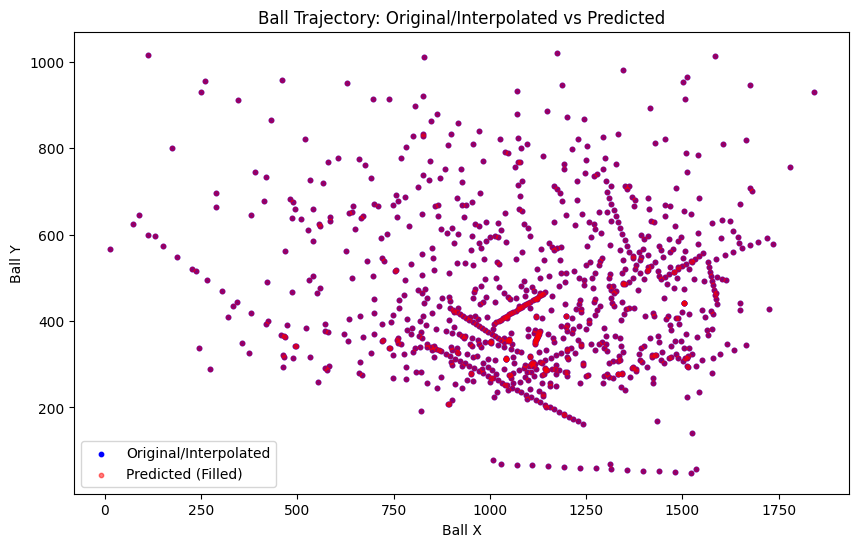

In [25]:
#Show Results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_full['ball_x'], df_full['ball_y'], c='blue', s=10, label='Original/Interpolated')
plt.scatter(df_predicted['ball_x'], df_predicted['ball_y'], c='red', s=10, alpha=0.5, label='Predicted (Filled)')
plt.xlabel('Ball X')
plt.ylabel('Ball Y')
plt.title('Ball Trajectory: Original/Interpolated vs Predicted')
plt.legend()
plt.show()
